# PreProcessing Demonstration

* **Last Modified**: 10-03-2021
* **Authors**: J. Emmanuel Johnson, Satyarth Praveen, Nadia Ahmed, Nicholas Roth
---
#### Brief Description

In this notebook, we will explore some ways that we can do *augmentations* that are necessary for machine learning purposes. The image data that we receive is not often ready for ML models. We often need to do further transformations before we input them into our machine learning model. Augmentation serves a few purposes:

1. It makes our models more robust to augmentations that we may find in the real world.
2. It can potentially expand our training dataset more by including "augmented" data.

Often times this functionality is hidden within the code but in this notebook, we expose the user step-by-step for how they can reproduce some of the augmentations used within the WorldFloods dataset. We hope this will not only provide understanding and explainability, but also spark some future research purposes.

---
#### TLDR

> Augmentations are important are a crucial component of an ML pipeline. This notebook will demonstrate how we can do this for the WorldFloods Dataset in particular.

> It uses the WorldFloodsDatasetTiled class that internally tiles the input image and masks. Objects of this class can also be initialized with the transformations to apply transformation to the tiled samples.

> This is useful because it complies with the pytorch datasets that can directly be used for training models.
---

---
#### More Information

* [PyTorch TorchVision Demo](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)


## Package Preamble

For starters, we want to import the necessary packages. We will outline which ones they are below and why we're using them.

In [2]:
# ====================================================
# Helpful trick for loading the directories correction
# ====================================================
import sys, os
from pathlib import Path
from pyprojroot import here
# spyder up to find the root
root = here(project_files=[".here"])
# append to path
sys.path.append(str(here()))

# ====================================================
# CUSTOM import for pytorch compatible Dataset class
# ====================================================
from src.data.worldfloods.dataset import WorldFloodsDatasetTiled

# ====================================================
# Imports for the transformations
# ====================================================
import albumentations
import src.preprocess.transformations as transformations
from src.preprocess.worldfloods import normalize as wf_normalization
from src.preprocess import tiling, utils as putils

# ====================================================
# Standard Packages
# ====================================================
import numpy as np
import copy

# MATPLOTLIB Settings
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# RASTERIO imports
from rasterio import plot as rasterioplt

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Downloading Demo Image

First and foremost, we need a demo image to demonstrate the transformations and visualizations. It is tiled while reading from the WorldFloodsDatasetTiled object. 

The path of the image is exactly the same for both the input image and the groundtruth with the only difference being the `S2` vs `GT/{version}` in the respective image path. This is demonstrated in the code. This makes the directory structure fairly simple to access data for the later modules of the pipeline.

The image is downloaded from the bucket for demonstration. Let's take a peek.

In [3]:
# from test.data.worldfloods.test_download import download_demo_image
from src.data import utils as dutils
from pathlib import Path

s2_prefix = "S2"
gt_prefix = "GT/V_1_1"

s2_demo_image = f"gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/{s2_prefix}/EMSR501/AOI01/EMSR501_AOI01_DEL_MONIT01_r1_v1.tif"
gt_demo_image = f"gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/{gt_prefix}/EMSR501/AOI01/EMSR501_AOI01_DEL_MONIT01_r1_v1.tif"

# Local destination directory
s2_destination_dir = Path(root).joinpath(f"datasets/demo_images/{s2_prefix}")
gt_destination_dir = Path(root).joinpath(f"datasets/demo_images/{gt_prefix}")

# Download demo image to local directory
s2_demo_gcp_path = dutils.GCPPath(s2_demo_image)
s2_demo_gcp_path.download_file_from_bucket(s2_destination_dir)

gt_demo_gcp_path = dutils.GCPPath(gt_demo_image)
gt_demo_gcp_path.download_file_from_bucket(gt_destination_dir)



Folder '/home/satyarth934/projects/ml4floods/datasets/demo_images/S2' Is Already There.
Folder '/home/satyarth934/projects/ml4floods/datasets/demo_images/GT/V_1_1' Is Already There.


PosixPath('/home/satyarth934/projects/ml4floods/datasets/demo_images/GT/V_1_1/EMSR501_AOI01_DEL_MONIT01_r1_v1.tif')

### Checking to ensure that the images were downloaded correctly in the respective folder.

In [4]:
!ls -lht $s2_destination_dir/
print("---")
!ls -lht $gt_destination_dir/

total 687M
-rw-rw-r-- 1 satyarth934 satyarth934 687M Mar  8 22:46 EMSR501_AOI01_DEL_MONIT01_r1_v1.tif
---
total 25M
-rw-rw-r-- 1 satyarth934 satyarth934 25M Mar  9 22:21 EMSR501_AOI01_DEL_MONIT01_r1_v1.tif


## WorldFloodsDatasetTiled 

#### So now, we can initalize our predefined `WorldFloodsDatasetTiled` class.

In [5]:
# Define constants
image_files = [
    "/home/satyarth934/projects/ml4floods/datasets/demo_images/S2/EMSR501_AOI01_DEL_MONIT01_r1_v1.tif"
]
image_prefix = "S2"
gt_prefix = "GT/V_1_1"
tile_height = tile_width = 256

# Demo tile index
dt_idx = 100

# Intialize worldfloods PyTorch Dataset
pt_ds_orig = WorldFloodsDatasetTiled(
    list_of_windows=utils.get_list_of_window_slices(
        file_names=image_files, window_size=tiling.WindowSize(height=tile_height, width=tile_width)
    ),
    image_prefix=image_prefix,
    gt_prefix=gt_prefix,
)

pt_ds = copy.copy(pt_ds_orig)

## Visualizing the original Image Tile and Mask

Number of Images: 288
Image Size: (13, 256, 256)
Mask Size: (1, 256, 256)


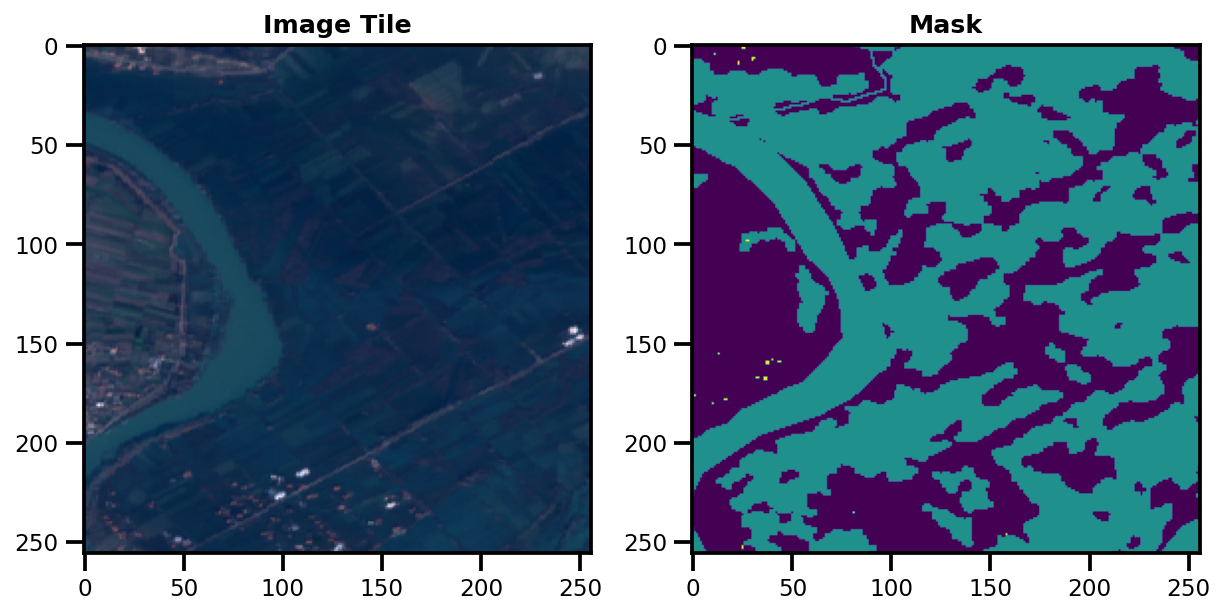

In [7]:
# Defining the plot function
def plot_images(demo_image_dict):
    # get the image and mask from the input dictionary
    image, mask = demo_image_dict["image"], demo_image_dict["mask"]
    print(f"Image Size: {image.shape}\nMask Size: {mask.shape}")
    
    # demo plot
    fig, ax = plt.subplots(ncols=2, figsize=(10, 20))
    
    # plot the image
    rgb = np.clip(image[(3,2,1),...]/3000.,0,1)
    rgb = np.interp(rgb, (rgb.min(), rgb.max()), (0, 255)).astype("uint8") 
    rasterioplt.show(rgb, transform=None, title="Image Tile", ax=ax[0])
    
    # plot the mask
    rasterioplt.show(mask, transform=None, title="Mask", ax=ax[1])
    

# Calling the plot function to visualize the original image and the corresponding mask.
print(f"Number of Images: {len(pt_ds_orig)}")
plot_images(pt_ds_orig[dt_idx])

#### Nice Attributes

There are some nifty attributes available now that we have our Dataset. Firstly, we can get the length (number of image tiles) as well as explicitly extract the images via the index.

#### Note: **Image Shapes**

So notice how the image shapes are `(Channel, Height, Width)`. This is the default pattern that Rasterio and PyTorch outputs. Since we are heavily dependent upon `rasterio` and `pytorch` so we stick with this as the default. 

For other libraries like `scikit-image`, `pillow` and `matplotlib`, we use the `(Height, Width, Channel)`. So for example, if we want to plot this, then we need to change the shape to accommadate the shape size.

## Covariance plot between different channels of the input image.

This is a visual metric to show how the data and the correlation between the data changes as different transformations are applied to the images. For the sake of the demonstration, the covariance matrix is computed using the RGB channels.

(3, 256, 256)


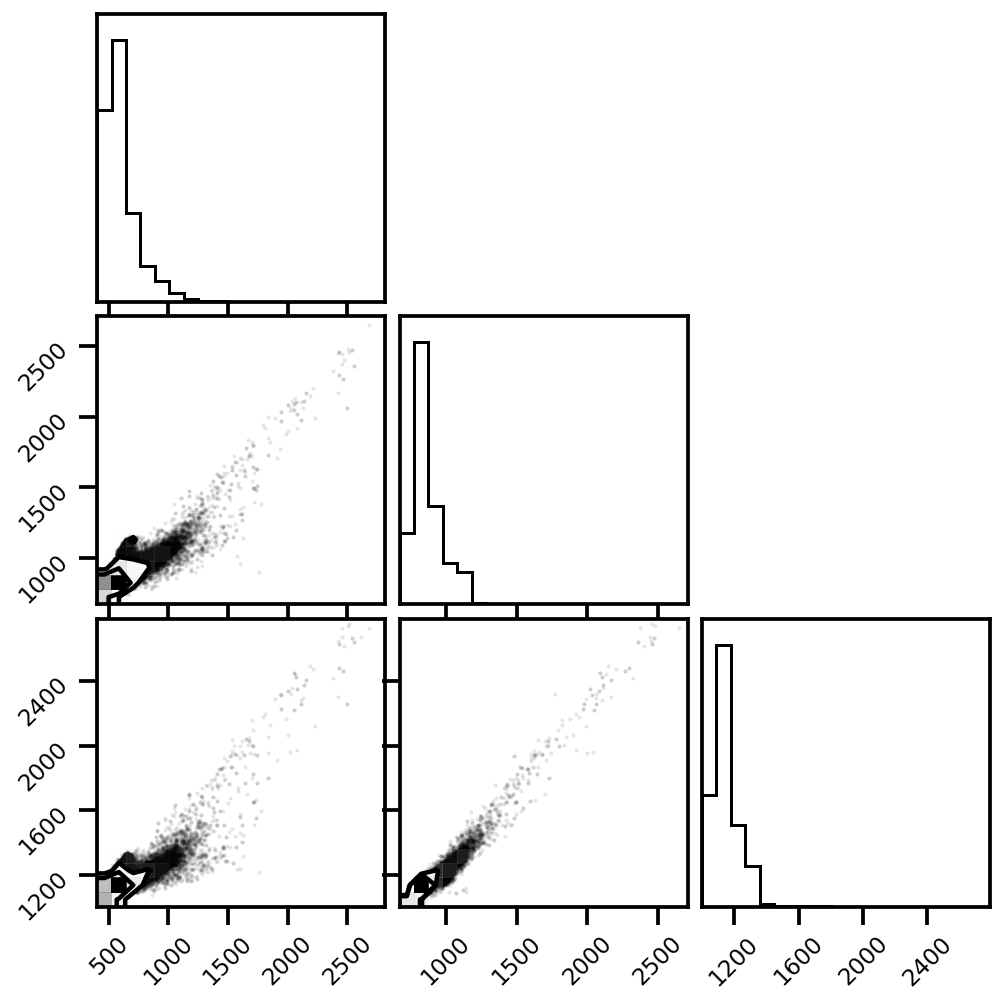

In [8]:
import corner

# t = pt_ds[dt_idx]["image"][5:8]
t = pt_ds_orig[dt_idx]["image"][(3,2,1), ...]
print(t.shape)
t = rasterioplt.reshape_as_image(t).reshape(t.shape[1]*t.shape[2], t.shape[0])

figure = corner.corner(t)

---
## Transformations

### Utility

---
#### Permute Channels

This is a simple permutation of the channels. In the case that the dataset was in a different order or we need to change the order, this transform would do the following:

$$
\text{Height}\times\text{Width}\times\text{Channels} \rightarrow \text{Channels}\times\text{Height}\times\text{Width} 
$$

On the contrary, the inverse permute channels transform does the following:

$$
\text{Channels}\times\text{Height}\times\text{Width} \rightarrow \text{Height}\times\text{Width}\times\text{Channels}
$$

Again, this is **mainly** for the other libraries.

In [9]:
print(f"Original Image (shape):\n{pt_ds_orig[dt_idx]['image'].shape}")

Original Image (shape):
(13, 256, 256)


In [10]:
transform_invpermutechannels = transformations.InversePermuteChannels()
transform_permutechannels = transformations.PermuteChannels()

pt_ds = WorldFloodsDatasetTiled(
    list_of_windows=utils.get_list_of_window_slices(
        file_names=image_files, window_size=tiling.WindowSize(height=tile_height, width=tile_width)
    ),
    image_prefix=image_prefix,
    gt_prefix=gt_prefix,
    transforms=transform_invpermutechannels
)

print(f"Tensor Flavour Image (shape):\n{pt_ds[dt_idx]['image'].shape}")


# create composite transform from package
# Application of inverse permute channels followed by 
# permute channels will lead to the input being unchanged.
mega_transform = albumentations.Compose([
    transform_invpermutechannels, 
    transform_permutechannels
    ])

pt_ds = WorldFloodsDatasetTiled(
    list_of_windows=utils.get_list_of_window_slices(
        file_names=image_files, window_size=tiling.WindowSize(height=tile_height, width=tile_width)
    ),
    image_prefix=image_prefix,
    gt_prefix=gt_prefix,
    transforms=mega_transform
)

print(f"Original Image (shape):\n{pt_ds[dt_idx]['image'].shape}")

Tensor Flavour Image (shape):
(256, 256, 13)
Original Image (shape):
(13, 256, 256)


---
#### To Tensor

This transforms the type of the matrices to a tensor. Typically this is the **last** transform that we do.

In [11]:
transform_totensor = transformations.ToTensor()

# pt_ds = WorldFloodsDatasetTiled(image_files, image_prefix, gt_prefix, transforms=transform_totensor)
pt_ds = WorldFloodsDatasetTiled(
    list_of_windows=utils.get_list_of_window_slices(
        file_names=image_files, window_size=tiling.WindowSize(height=tile_height, width=tile_width)
    ),
    image_prefix=image_prefix,
    gt_prefix=gt_prefix,
    transforms=transform_totensor
)

print(f"Image (type): {type(pt_ds[dt_idx]['image'])}")

Image (type): <class 'torch.Tensor'>


---
### Specialized

#### #1. **Normalize**

Image Size: (13, 256, 256)
Mask Size: (1, 256, 256)


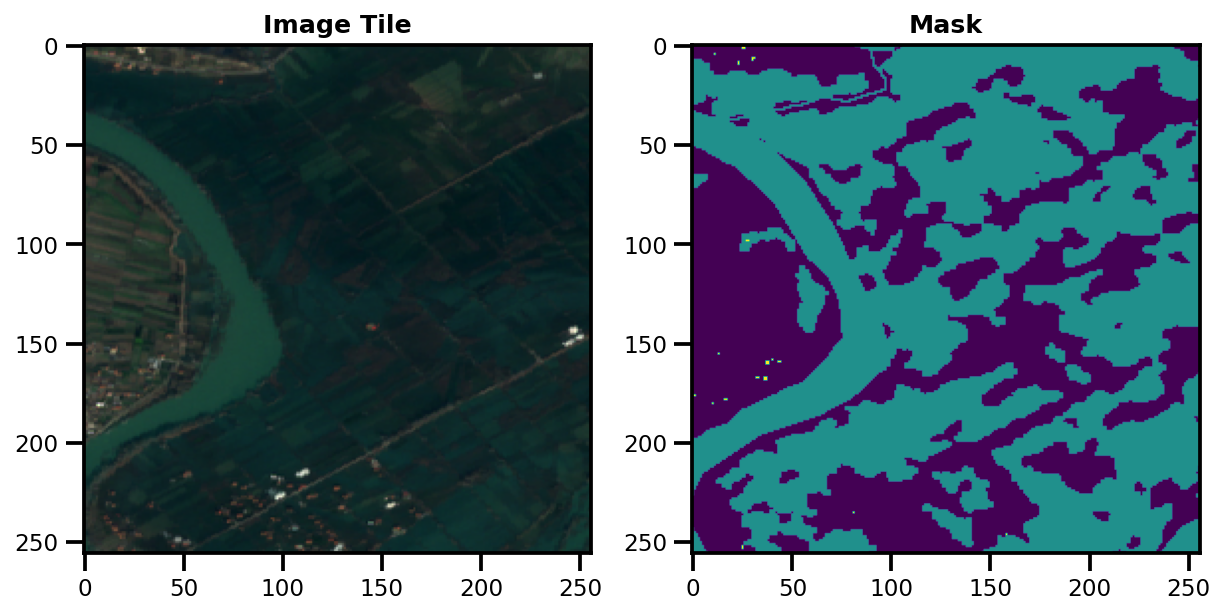

In [12]:
use_channels = "all"
channel_mean, channel_std = wf_normalization.get_normalisation(use_channels)
transform_normalize = transformations.Normalize(
    mean=channel_mean, 
    std=channel_std, 
    max_pixel_value=1
)
transform_invpermutechannels = transformations.InversePermuteChannels()
transform_permutechannels = transformations.PermuteChannels()

# Composing multiple transformations together
mega_transform = albumentations.Compose([
    transform_invpermutechannels,
    transform_normalize,
    transform_permutechannels
    ])

pt_ds = WorldFloodsDatasetTiled(
    list_of_windows=utils.get_list_of_window_slices(
        file_names=image_files, window_size=tiling.WindowSize(height=tile_height, width=tile_width)
    ),
    image_prefix=image_prefix,
    gt_prefix=gt_prefix,
    transforms=mega_transform
)


# Plotting the normalized image
def plot_images_plt(demo_image_dict):

    # get the image and mask from the input dictionary
    image, mask = demo_image_dict["image"], demo_image_dict["mask"]
    print(f"Image Size: {image.shape}\nMask Size: {mask.shape}")
    
    # demo plot
    fig, ax = plt.subplots(ncols=2, figsize=(10, 20))
    
    # plot the image
    check_img = image[(3,2,1), ...]
    check_img = np.interp(check_img, (check_img.min(), check_img.max()), (0, 255)).astype("uint8")

    rasterioplt.show(check_img, transform=None, title="Image Tile", ax=ax[0])
    
    # plot the mask
    rasterioplt.show(mask, transform=None, title="Mask", ax=ax[1])

    
plot_images_plt(pt_ds[dt_idx])

#### #2. **ShiftScaleRotate (Per Band)**

(256, 256, 13)
Image Size: (13, 256, 256)
Mask Size: (1, 256, 256)


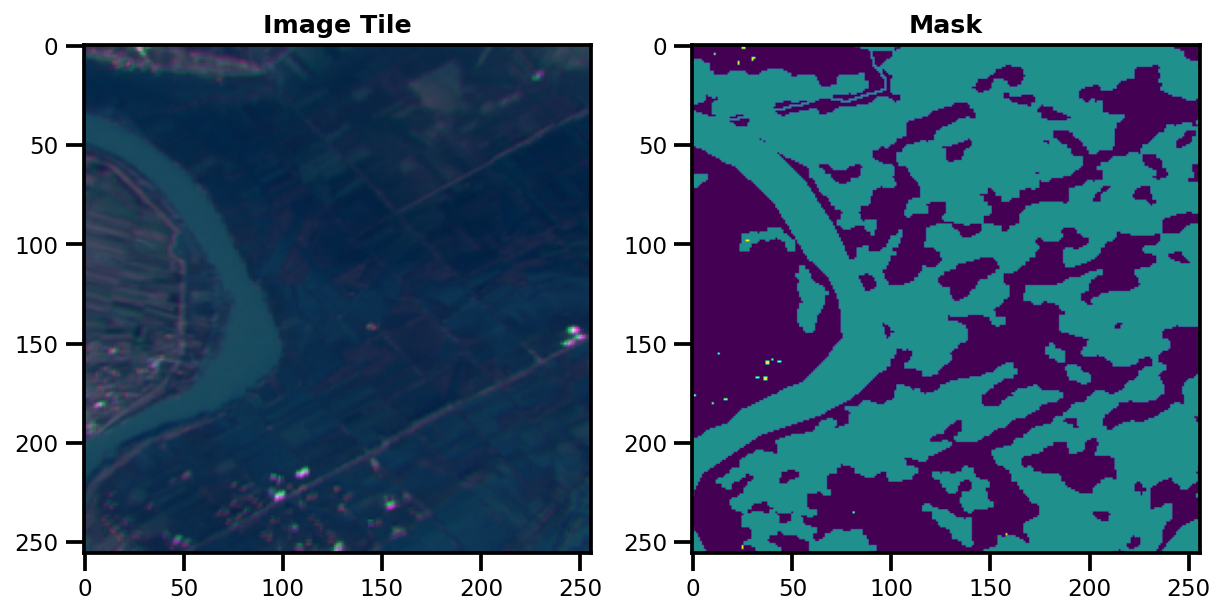

In [13]:
transform_scaling = transformations.ShiftScaleRotate(
    shift_limit=0.001, 
    scale_limit=0.01, 
    rotate_limit=0.01, p=1.0)
transform_channeljitter= transformations.PerChannel(
    transforms=[transform_scaling]
)

mega_transform = albumentations.Compose([
    transform_invpermutechannels,
    transform_channeljitter,
    transform_permutechannels
    ])

pt_ds = WorldFloodsDatasetTiled(
    list_of_windows=utils.get_list_of_window_slices(
        file_names=image_files, window_size=tiling.WindowSize(height=tile_height, width=tile_width)
    ),
    image_prefix=image_prefix,
    gt_prefix=gt_prefix,
    transforms=mega_transform
)

plot_images(pt_ds[dt_idx])

#### #3. **Flip**

Image Size: (13, 256, 256)
Mask Size: (1, 256, 256)


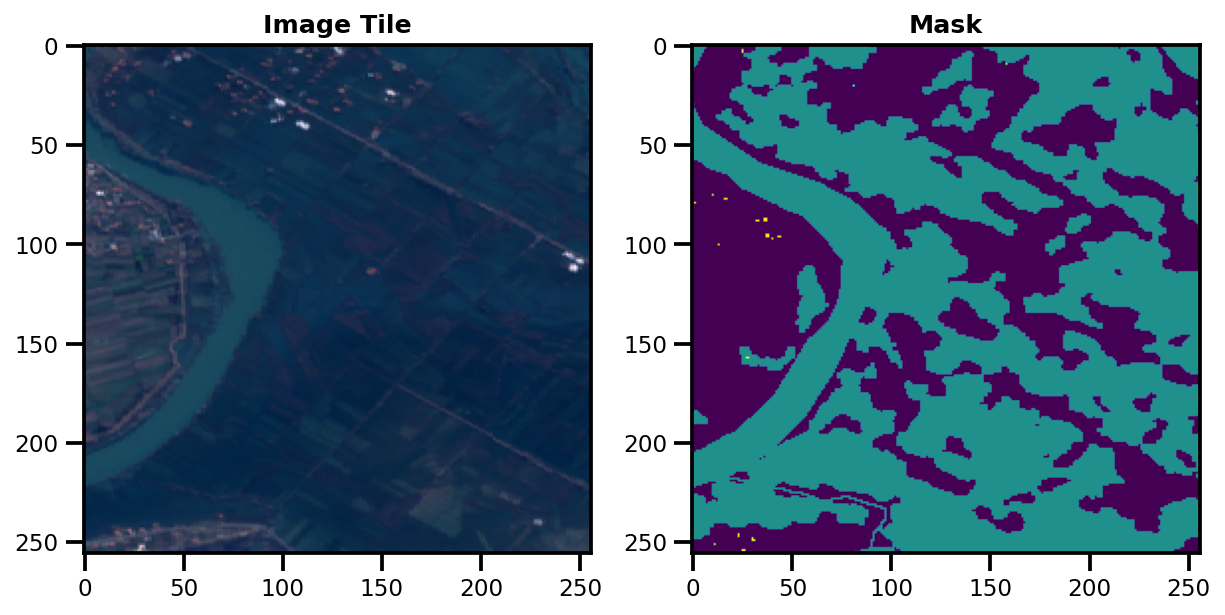

In [14]:
transform_flip = transformations.Flip(always_apply=True, p=1.0)

mega_transform = albumentations.Compose([
    transform_invpermutechannels,
    transform_flip,
    transform_permutechannels
])

pt_ds = WorldFloodsDatasetTiled(
    list_of_windows=utils.get_list_of_window_slices(
        file_names=image_files, window_size=tiling.WindowSize(height=tile_height, width=tile_width)
    ),
    image_prefix=image_prefix,
    gt_prefix=gt_prefix,
    transforms=mega_transform
)

plot_images(pt_ds[dt_idx])

#### #4. **RandomRotate90**

Image Size: (13, 256, 256)
Mask Size: (1, 256, 256)


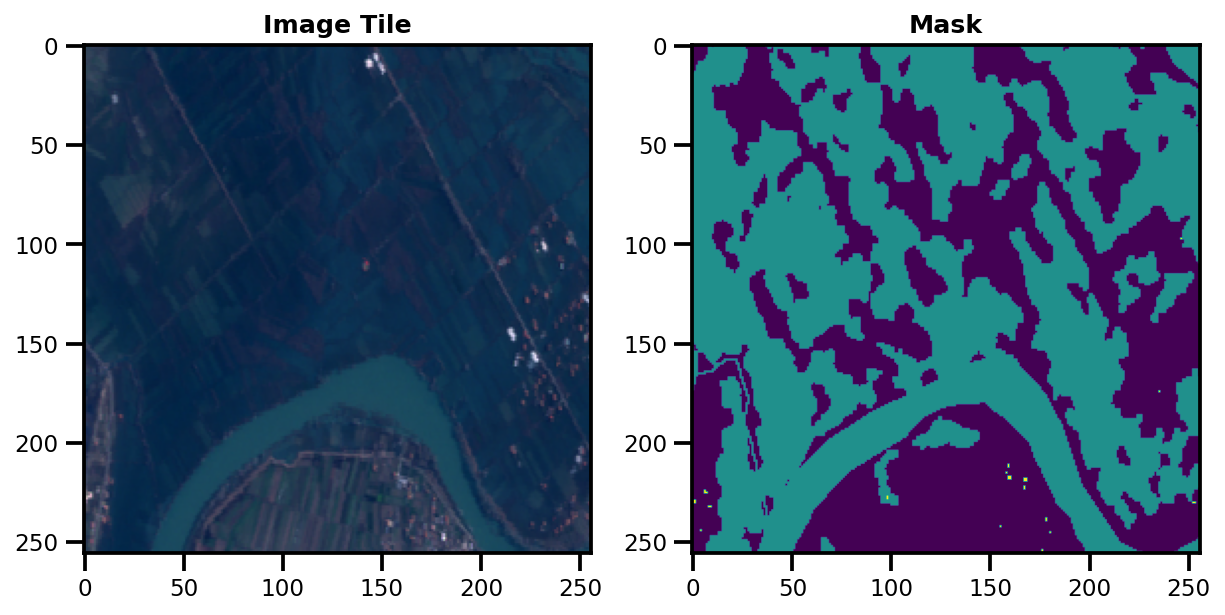

In [15]:
transform_rr90 = transformations.RandomRotate90(always_apply=True, p=1.0)

mega_transform = albumentations.Compose([
    transform_invpermutechannels,
    transform_rr90,
    transform_permutechannels
])

pt_ds = WorldFloodsDatasetTiled(
    list_of_windows=utils.get_list_of_window_slices(
        file_names=image_files, window_size=tiling.WindowSize(height=tile_height, width=tile_width)
    ),
    image_prefix=image_prefix,
    gt_prefix=gt_prefix,
    transforms=mega_transform
)

plot_images(pt_ds[dt_idx])

#### #5. **Motion Blur**

Image Size: (13, 256, 256)
Mask Size: (1, 256, 256)


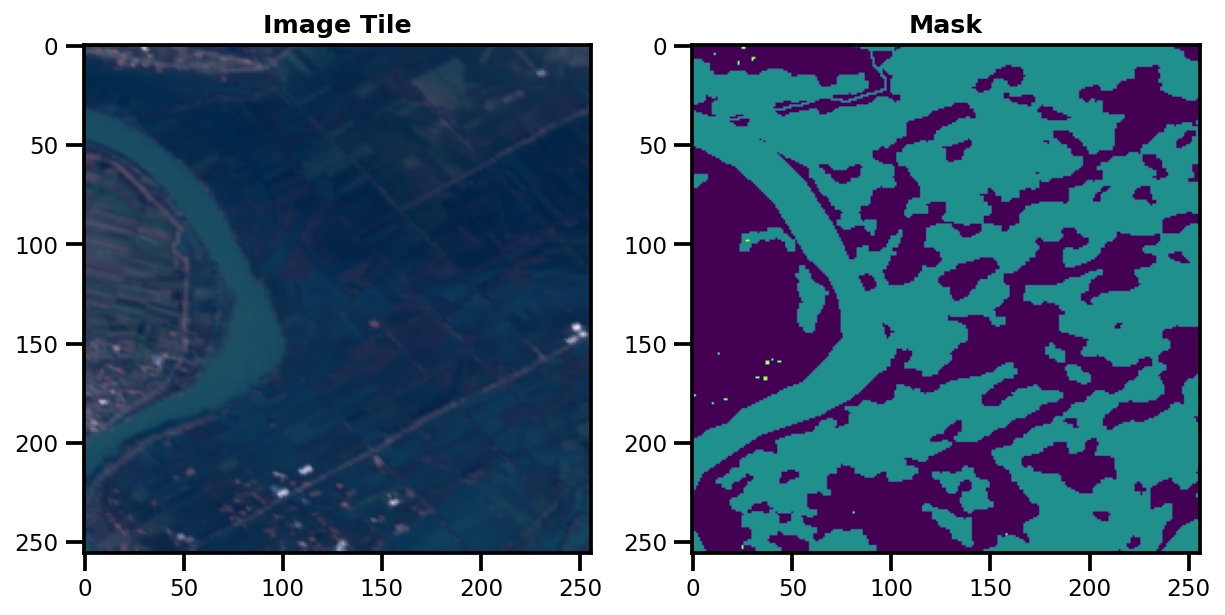

In [16]:
transform_motionblur = transformations.MotionBlur(blur_limit=7, always_apply=True, p=1.0)

mega_transform = albumentations.Compose([
    transform_invpermutechannels,
    transform_motionblur,
    transform_permutechannels
])

pt_ds = WorldFloodsDatasetTiled(
    list_of_windows=utils.get_list_of_window_slices(
        file_names=image_files, window_size=tiling.WindowSize(height=tile_height, width=tile_width)
    ),
    image_prefix=image_prefix,
    gt_prefix=gt_prefix,
    transforms=mega_transform
)

plot_images(pt_ds[dt_idx])

#### #6. **ReSize**

Image Size: (13, 64, 64)
Mask Size: (1, 256, 256)


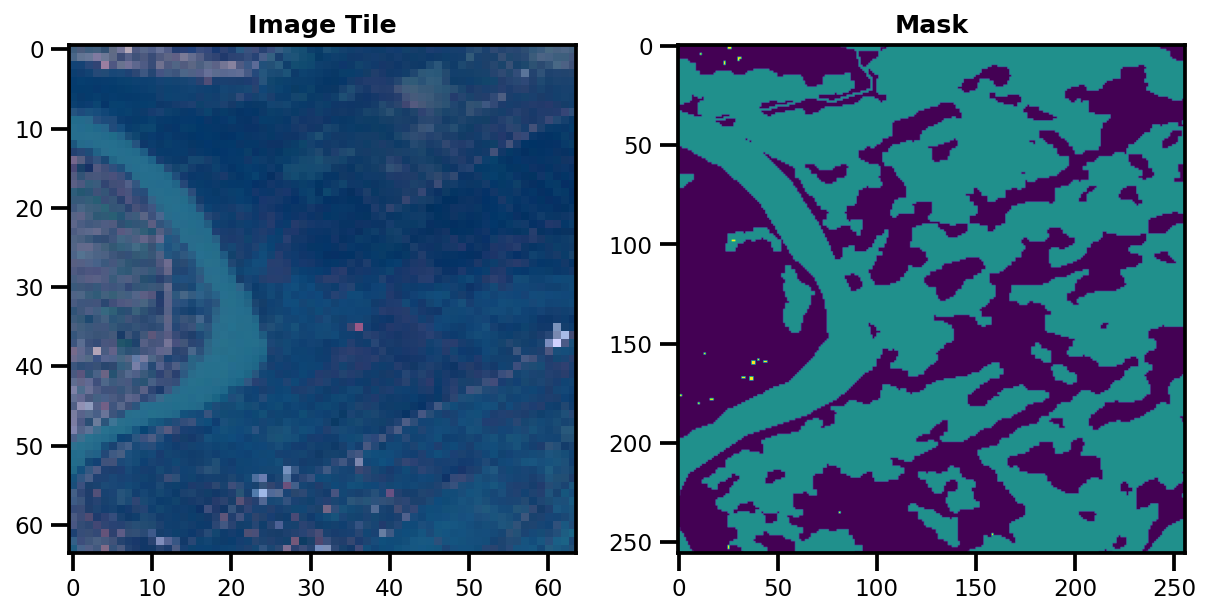

In [17]:
transform_invpermutechannels = transformations.InversePermuteChannels()
transform_resize = transformations.ResizeFactor(4)
transform_permutechannels = transformations.PermuteChannels()

mega_transform = albumentations.Compose([
    transform_invpermutechannels, 
    transform_resize,
    transform_permutechannels
])

pt_ds = WorldFloodsDatasetTiled(
    list_of_windows=utils.get_list_of_window_slices(
        file_names=image_files, window_size=tiling.WindowSize(height=tile_height, width=tile_width)
    ),
    image_prefix=image_prefix,
    gt_prefix=gt_prefix,
    transforms=mega_transform
)

plot_images(pt_ds[dt_idx])

---

## Stacking All Transforms Together!

Image Size: (13, 64, 64)
Mask Size: (1, 256, 256)


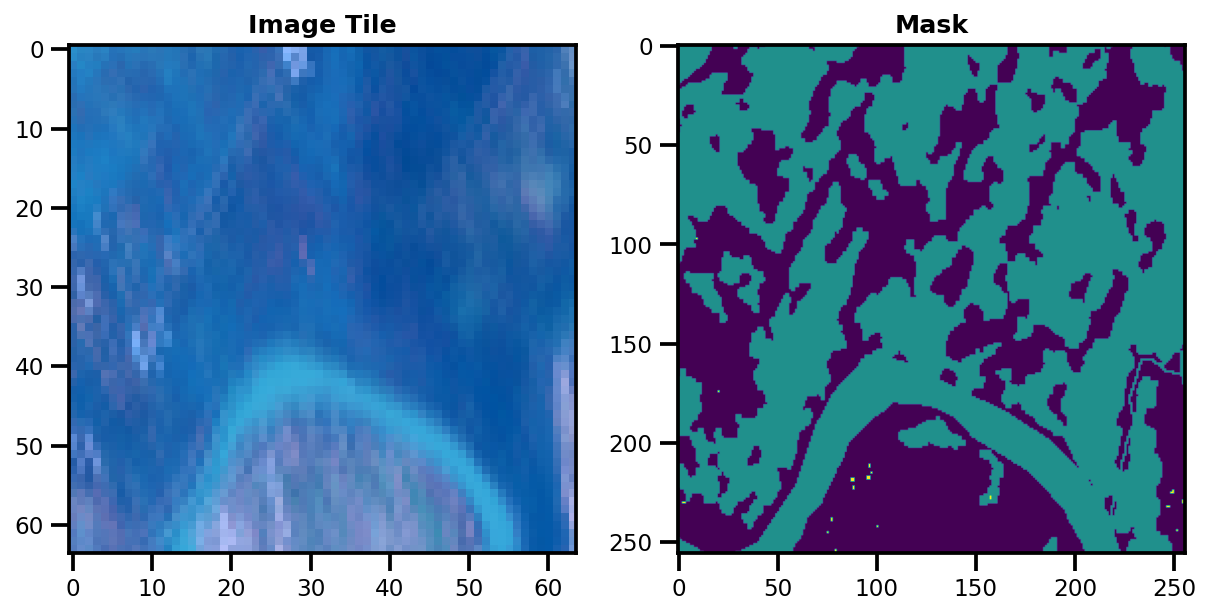

In [18]:
# Stacked Transforms
mega_transform = transformations.Compose([
    transform_invpermutechannels, 
    transform_resize,
    transform_motionblur,
    transform_rr90,
    transform_flip,
    transform_permutechannels,
])

pt_ds = WorldFloodsDatasetTiled(
    list_of_windows=utils.get_list_of_window_slices(
        file_names=image_files, window_size=tiling.WindowSize(height=tile_height, width=tile_width)
    ),
    image_prefix=image_prefix,
    gt_prefix=gt_prefix,
    transforms=mega_transform
)

plot_images(pt_ds[dt_idx])

---
## Covariance plot between different channels of the input image

#### Comparing the plot for the original and the transformed data. A difference in correlation can be seen in the plot of the transformed data.

Original image plot
(3, 256, 256)


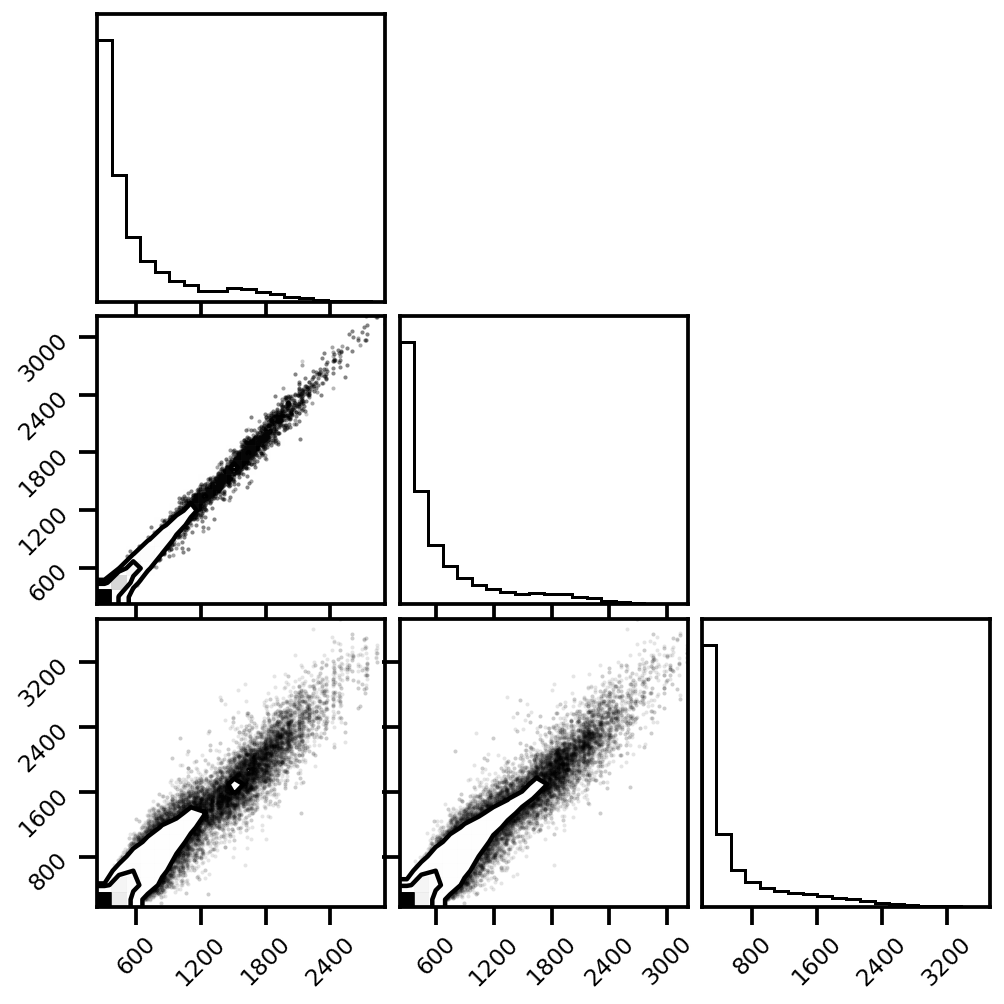

In [19]:
# Original images
print("Original image plot")

t = pt_ds_orig[dt_idx]["image"][5:8]
print(t.shape)
t = rasterioplt.reshape_as_image(t).reshape(t.shape[1]*t.shape[2], t.shape[0])

figure = corner.corner(t)

(3, 64, 64)


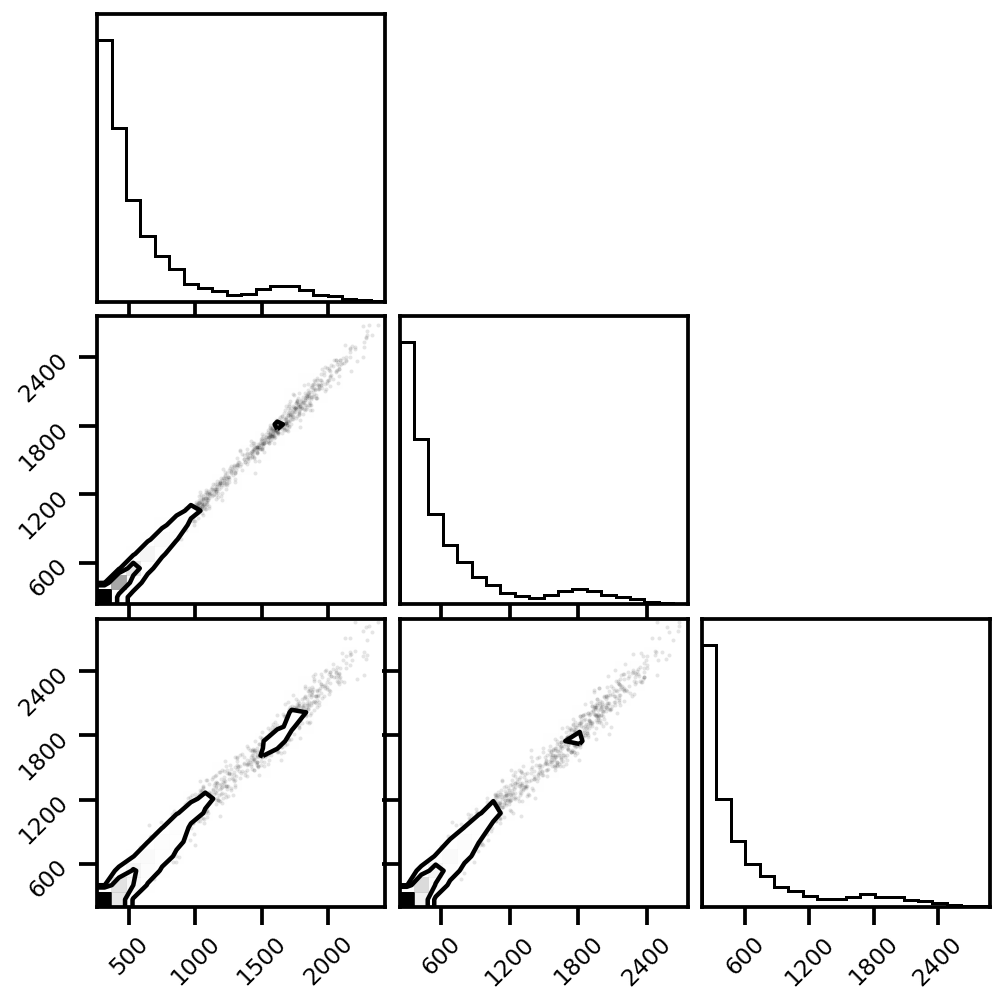

In [20]:
# Transformed images
import corner

t = pt_ds[dt_idx]["image"][5:8]
print(t.shape)
t = rasterioplt.reshape_as_image(t).reshape(t.shape[1]*t.shape[2], t.shape[0])

figure = corner.corner(t)

---
## Config Files

The above process of performing transformations is simplified using a config file.
The programmer does not need to edit the transformation functions within the code each time he/she decides to modify the transformations on the input data. The parameters can be defined within a json config file and can directly be used to automatically generate the transformations.

In [21]:
from src.models.utils.configuration import AttrDict
from src.data.worldfloods.configs import CHANNELS_CONFIGURATIONS

opt = {
    "data_params": {
        "bucket_id": "ml4floods",
        "path_to_splits": "worldfloods/public",
        "input_folder": "S2",
        "target_folder": "gt",
        "batch_size": 8,
        "window_size": [256, 256],
        "bands": "all",
        "train_transformation": {
            "num_classes": 3,
            "resizefactor": {
                "downsampling_factor": 3,
                "p": 1.0
            },
            "normalize": True,
            "shiftscalerotate": {
                "shift_limit": 0.001,
                "scale_limit": 0.01,
                "rotate_limit": 0.01,
                "p": 0.5
            },
            "gaussnoise": {
                "var_limit_lower": 1e-6,
                "var_limit_upper": 1e-3,
                "p": 0.2
            },
            "motionblur": {
                "blur_limit": 7,
                "always_apply": False
            },
            "randomrotate90": {
                "p": 0.5,
                "always_apply": False
            },
            "flip": {
                "p": 0.5,
                "always_apply": False
            },
            "totensor": True,
            "use_channels": "all"
        },
        "test_transformation": {
            "num_classes": 3,
            "resizefactor": None,
            "shiftscalerotate": None,
            "gaussnoise": None,
            "motionblur": None,
            "totensor": True,
            "use_channels": "all",
            "normalize": True
        }
    }
}
opt = AttrDict.from_nested_dicts(opt)

In [22]:
opt

{'data_params': {'bucket_id': 'ml4floods',
  'path_to_splits': 'worldfloods/public',
  'input_folder': 'S2',
  'target_folder': 'gt',
  'batch_size': 8,
  'window_size': [256, 256],
  'bands': 'all',
  'train_transformation': {'num_classes': 3,
   'resizefactor': {'downsampling_factor': 3, 'p': 1.0},
   'normalize': True,
   'shiftscalerotate': {'shift_limit': 0.001,
    'scale_limit': 0.01,
    'rotate_limit': 0.01,
    'p': 0.5},
   'gaussnoise': {'var_limit_lower': 1e-06,
    'var_limit_upper': 0.001,
    'p': 0.2},
   'motionblur': {'blur_limit': 7, 'always_apply': False},
   'randomrotate90': {'p': 0.5, 'always_apply': False},
   'flip': {'p': 0.5, 'always_apply': False},
   'totensor': True,
   'use_channels': 'all'},
  'test_transformation': {'num_classes': 3,
   'resizefactor': None,
   'shiftscalerotate': None,
   'gaussnoise': None,
   'motionblur': None,
   'totensor': True,
   'use_channels': 'all',
   'normalize': True}}}

In [23]:
# extract train transformation params
transform_params = opt.data_params.train_transformation

channel_mean, channel_std = wf_normalization.get_normalisation(transform_params.use_channels)

# define composite transformation
train_transform = transformations.Compose([
    transformations.InversePermuteChannels(), 
    transformations.RandomRotate90(**transform_params.randomrotate90),
    transformations.Flip(**transform_params.flip),
    transformations.Normalize(
        mean=channel_mean, 
        std=channel_std, 
        max_pixel_value=1),
    transformations.PermuteChannels(), 
])


# initialize dataset
pt_ds = WorldFloodsDatasetTiled(
    list_of_windows=utils.get_list_of_window_slices(
        file_names=image_files, window_size=tiling.WindowSize(height=tile_height, width=tile_width)
    ),
    image_prefix=image_prefix,
    gt_prefix=gt_prefix,
    transforms=mega_transform
)

Image Size: (13, 64, 64)
Mask Size: (1, 256, 256)


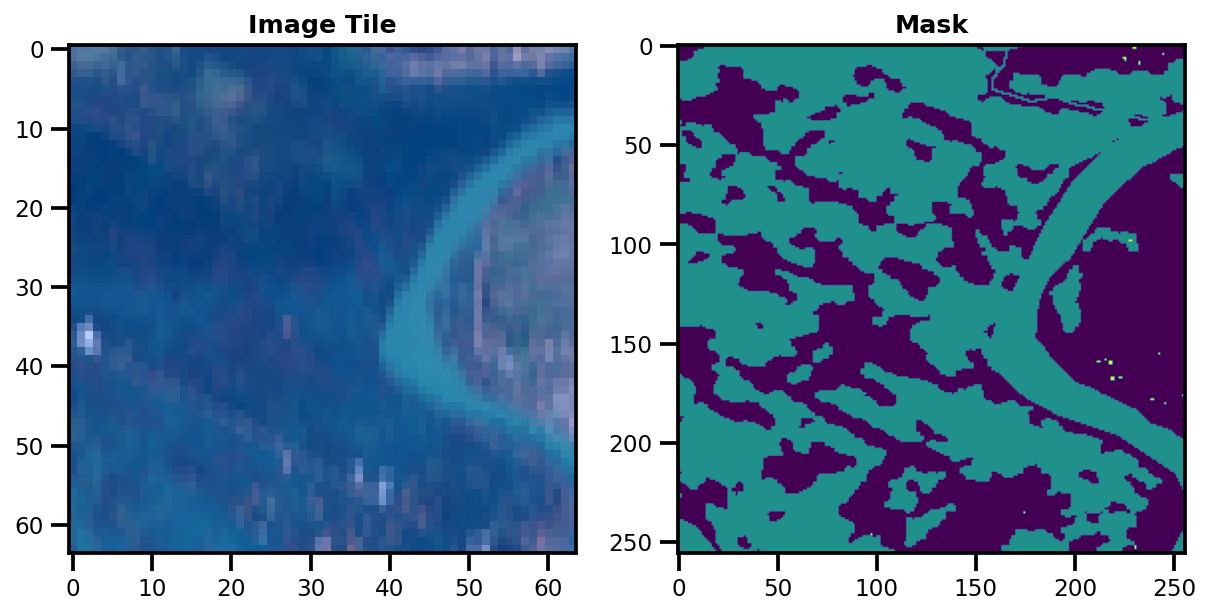

In [24]:
plot_images(pt_ds[dt_idx])